# Fraud Detection ML MODEL
### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np

# Machine learning models and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Handling imbalanced data (e.g., SMOTE)
from imblearn.over_sampling import SMOTE

# For handling missing data
from sklearn.impute import SimpleImputer

# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# Model selection and optimization
from sklearn.model_selection import GridSearchCV

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transactions = pd.read_csv("transactions_data.csv")

In [3]:
transactions

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,$40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,$4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN


In [4]:
transactions.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')

## Handling Fraud Labels
 - The fraud labels are stored in a separate dataset (`fraud_labels`).
 - Reset the index to ensure proper alignment during merging.
 - Rename the columns for clarity (`id` and `is_fraud`).
 - Display the first few rows of the fraud labels to confirm the changes.

# **Goal**: Prepare the fraud labels for merging with the main transaction dataset.


In [5]:
# Load fraud labels
fraud_labels = pd.read_json('train_fraud_labels.json')

In [6]:
print(fraud_labels.head())

         target
10649266     No
23410063     No
9316588      No
12478022     No
9558530      No


In [7]:
# Reset the index to make it a column
fraud_labels = fraud_labels.reset_index()

# Rename the columns
fraud_labels.columns = ['id', 'is_fraud']

# Verify the result
print(fraud_labels.head())


         id is_fraud
0  10649266       No
1  23410063       No
2   9316588       No
3  12478022       No
4   9558530       No


In [8]:
print(transactions.columns)
print(fraud_labels.columns)


Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')
Index(['id', 'is_fraud'], dtype='object')


### Cleaning the 'Amount' Column
#### - The `amount` column in the dataset contains a dollar sign (`$`) as part of the values.
#### - Use `replace()` to remove the `$` and convert the column to a float type.
#### Ensure the `amount` column is in a numeric format for analysis and modeling.


In [9]:
# Remove the '$' sign and convert to float
transactions['amount'] = transactions['amount'].replace('[\$,]', '', regex=True).astype(float)

In [10]:
# Merge transactions with fraud labels
transactions = transactions.merge(fraud_labels, on='id', how='left')

print(transactions.head())

        id                 date  client_id  card_id  amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  -77.00   
1  7475328  2010-01-01 00:02:00        561     4575   14.57   
2  7475329  2010-01-01 00:02:00       1129      102   80.00   
3  7475331  2010-01-01 00:05:00        430     2860  200.00   
4  7475332  2010-01-01 00:06:00        848     3915   46.41   

            use_chip  merchant_id merchant_city merchant_state      zip   mcc  \
0  Swipe Transaction        59935        Beulah             ND  58523.0  5499   
1  Swipe Transaction        67570    Bettendorf             IA  52722.0  5311   
2  Swipe Transaction        27092         Vista             CA  92084.0  4829   
3  Swipe Transaction        27092   Crown Point             IN  46307.0  4829   
4  Swipe Transaction        13051       Harwood             MD  20776.0  5813   

  errors is_fraud  
0    NaN       No  
1    NaN       No  
2    NaN       No  
3    NaN      NaN  
4    NaN       No  


In [11]:
transactions.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'is_fraud'],
      dtype='object')

In [12]:
# Drop unwanted columns
transactions = transactions.drop(columns=['id', 'date'])

transactions.columns

Index(['client_id', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'is_fraud'],
      dtype='object')

### Converting Fraud Labels to Binary
- Replace `yes` and `no` in the `is_fraud` column with binary values (1 for fraud, 0 for non-fraud).
- Verify the changes by displaying the first few rows of the `is_fraud` column.
#### Ensure the target variable is in a numeric format for modeling.


In [13]:
# Replace 'yes' with 1 and 'no' with 0 in the 'is_fraud' column
transactions['is_fraud'] = transactions['is_fraud'].replace({'yes': 1, 'no': 0})

transactions['is_fraud'].head()

0     No
1     No
2     No
3    NaN
4     No
Name: is_fraud, dtype: object

### Visualizing Fraud vs Non-Fraud Transactions
 - Use a `countplot` to visualize the distribution of fraud (`1`) and non-fraud (`0`) transactions.
 - Adjust the y-axis scale to log to handle large differences in counts.
#### **Objective**: Understand the class imbalance in the target variable.


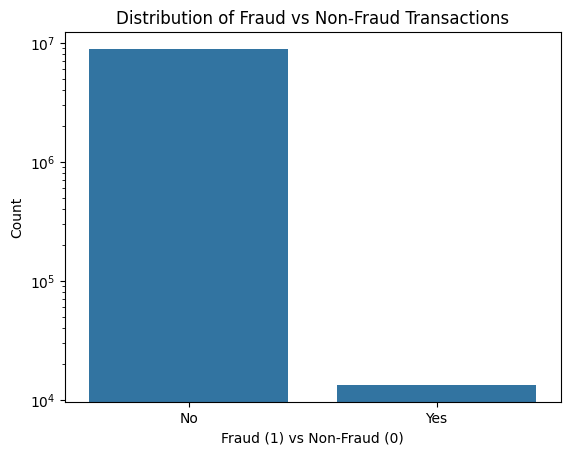

In [14]:
# Count the distribution of the target variable
sns.countplot(data=transactions, x='is_fraud')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Fraud (1) vs Non-Fraud (0)')
plt.ylabel('Count')
plt.yscale('log')  # Log scale helps with large differences in counts
plt.show()

In [15]:
# Count the number of fraud and non-fraud transactions
fraud_counts = transactions['is_fraud'].value_counts()
print(fraud_counts)


is_fraud
No     8901631
Yes      13332
Name: count, dtype: int64


In [16]:
transactions

,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,No
1,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,No
2,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,No
3,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,NaN
4,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
13305910,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN,No
13305911,1766,2066,12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN,No
13305912,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN,No
13305913,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN,NaN


In [17]:
# Drop rows where 'is_fraud' is NaN
transactions = transactions.dropna(subset=['is_fraud'])

# Verify the result
print(transactions['is_fraud'].isna().sum())  # This should return 0, indicating no NaN values


0


In [18]:
transactions

,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud
0,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,No
1,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,No
2,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,No
4,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,No
5,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...
13305905,672,5001,12.93,Chip Transaction,47508,Cosby,TN,37722.0,7230,NaN,No
13305906,1384,3723,67.01,Chip Transaction,58136,Williamson,GA,30292.0,5812,NaN,No
13305910,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN,No
13305911,1766,2066,12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN,No


In [19]:
transactions.columns


Index(['client_id', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'is_fraud'],
      dtype='object')

### Encoding Categorical Variables
 - Use `LabelEncoder` from `sklearn` to convert categorical columns into numeric values.
 - The categorical columns being encoded are: `use_chip`, `merchant_city`, `merchant_state`, and `errors`.
### **Goal**: Ensure all categorical features are represented numerically for machine learning algorithms.


In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
categorical_columns = ['use_chip', 'merchant_city', 'merchant_state', 'errors']
for col in categorical_columns:
    transactions[col] = label_encoder.fit_transform(transactions[col])

# Now, the 'use_chip' and other columns should be encoded as numeric values

/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_5375/2082828310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[col] = label_encoder.fit_transform(transactions[col])
/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_5375/2082828310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[col] = label_encoder.fit_transform(transactions[col])
/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_5375/2082828310.py:9: SettingWithCopyWarning: 
A value is trying 

### Separating Numeric and Categorical Columns
- Separate the columns into numeric and categorical based on their data types.
- Use `select_dtypes` to filter numeric and object (categorical) columns. 
### **Objective**: Understand the data structure and identify columns for further preprocessing.


In [21]:
numeric_columns = transactions.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = transactions.select_dtypes(include=['object']).columns

# Check the columns
print(numeric_columns)
print(categorical_columns)


Index(['client_id', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors'],
      dtype='object')
Index(['is_fraud'], dtype='object')


### Imputing Missing Values for Numeric Columns
 - Use `SimpleImputer` from `sklearn` to fill missing values in numeric columns.
 - Apply the **mean** strategy to replace missing values with the average of each column.

### **Goal**: Ensure there are no missing values in numeric columns before further processing.


In [22]:
from sklearn.impute import SimpleImputer

# Impute missing values in numeric columns using the mean
numeric_imputer = SimpleImputer(strategy='mean')
transactions[numeric_columns] = numeric_imputer.fit_transform(transactions[numeric_columns])


/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_5375/4205786619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[numeric_columns] = numeric_imputer.fit_transform(transactions[numeric_columns])


### Imputing Missing Values for Categorical Columns
 - Use `SimpleImputer` to handle missing values in categorical columns.
 - Apply the **most frequent** strategy to replace missing values with the mode of each column. 
### **Goal**: Ensure there are no missing values in categorical columns before encoding.


In [23]:
# Impute missing values in categorical columns using the mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
transactions[categorical_columns] = categorical_imputer.fit_transform(transactions[categorical_columns])


/var/folders/c2/h2s1ssjd2y994rq1jblvb0_c0000gn/T/ipykernel_5375/315866799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions[categorical_columns] = categorical_imputer.fit_transform(transactions[categorical_columns])


### One-Hot Encoding for Categorical Variables
 - Use `pd.get_dummies()` to convert categorical columns into dummy/indicator variables.
 - Set `drop_first=True` to avoid multicollinearity.
### **Objective**: Represent categorical variables as binary features to be compatible with machine learning models.


In [24]:
# Apply one-hot encoding to categorical columns
transactions = pd.get_dummies(transactions, columns=categorical_columns, drop_first=True)


### Verifying Preprocessed Data
 - Check for any remaining missing values using `isnull().sum()`.
 - Confirm all columns are numeric by inspecting their data types. 
### **Goal**: Ensure the dataset is fully prepared for modeling.


In [25]:
# Check the final dataset
print(transactions.isnull().sum())  # Ensure no missing values
print(transactions.dtypes)  # Ensure all columns are numeric


client_id         0
card_id           0
amount            0
use_chip          0
merchant_id       0
merchant_city     0
merchant_state    0
zip               0
mcc               0
errors            0
is_fraud_Yes      0
dtype: int64
client_id         float64
card_id           float64
amount            float64
use_chip          float64
merchant_id       float64
merchant_city     float64
merchant_state    float64
zip               float64
mcc               float64
errors            float64
is_fraud_Yes         bool
dtype: object


### Applying PCA for Dimensionality Reduction
 - Use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset.
 - Retain the top 10 components for simplicity and computational efficiency.
 - Convert the resulting principal components back into a DataFrame for further use. 
### **Goal**: Reduce the dataset's dimensionality while preserving most of the variance.


In [26]:
# Separate features (X) and target (y)
X = transactions.drop(columns=['is_fraud_Yes'])  # Drop the 'is_fraud_Yes' column, which is now the target
y = transactions['is_fraud_Yes']  # The target is now in 'is_fraud_Yes'


# Apply PCA to reduce dimensionality (e.g., to 10 components)
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Convert back to a DataFrame
transactions_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
transactions_pca['is_fraud'] = y


### Preparing Data for Model Training
 - Ensure the features (`X`) and target (`y`) are separated and ready for training.
 - This marks the end of the preprocessing and dimensionality reduction steps. 
### **Next Steps**: Train a classification model using the preprocessed data.


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# 1. Separate features (X) and target (y)
X = transactions.drop(columns=['is_fraud_Yes'])  # Remove the target column
y = transactions['is_fraud_Yes']

In [28]:
# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=330)


### Random Forest Classifier
- **What is it?**
  - A Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs to make more accurate predictions.
  - It reduces the risk of overfitting compared to a single decision tree.

- **Why Random Forest?**
  - Handles large datasets with high dimensionality effectively.
  - Robust to outliers and missing data.
  - Works well with both classification and regression tasks.
  - Provides feature importance, helping to identify the most impactful variables.

- **Why we chose it?**
  - Given the nature of the fraud detection problem (imbalanced data and complex patterns), Random Forest is a good choice for its accuracy and ability to handle diverse data types.


In [29]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=330, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=330)

In [30]:
y_pred = rf_model.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98   1780420
        True       0.03      0.92      0.07      2573

    accuracy                           0.96   1782993
   macro avg       0.52      0.94      0.52   1782993
weighted avg       1.00      0.96      0.98   1782993



### Initial Random Forest Model Results on Imbalanced Dataset

### **Model Performance Overview:**
- The Random Forest model was trained on a highly imbalanced dataset, where the majority of the data corresponds to the `False` (non-fraud) class.
- The model demonstrates high **accuracy** due to the dominance of the majority class but performs poorly for the minority (`True` or fraud) class.

### **Key Metrics:**
- **Precision**:
  - For `False` (non-fraud): Nearly perfect (1.00), indicating most predicted non-fraud cases are correct.
  - For `True` (fraud): Very low (0.03), meaning the model rarely identifies fraud correctly.
- **Recall**:
  - For `True` (fraud): Surprisingly high (0.92), showing the model identifies most fraud cases but likely misclassifies them as non-fraud often.
- **F1-Score**:
  - For `True` (fraud): Very low (0.07), highlighting poor balance between precision and recall.

### **Takeaway:**
- The **accuracy (0.96)** is misleading as it reflects the imbalance, not actual model performance.
- The **macro avg F1-score (0.52)** and **precision for fraud (0.03)** indicate the model struggles to handle the minority fraud class.
- This result emphasizes the need to address the imbalance in the dataset (e.g., using techniques like SMOTE, undersampling, or class weighting) to improve the model's performance on fraud detection.


In [32]:
print(len(rf_model.estimators_))  # Should print a number > 0

100


In [33]:
transactions.columns

Index(['client_id', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors',
       'is_fraud_Yes'],
      dtype='object')

### Creating a Balanced Subsample and Training the Model

### **Why Create a Balanced Subsample?**
- The original dataset contains **9 million rows** with a high class imbalance, making it computationally expensive to process using techniques like SMOTE.
- To address this, we created a **balanced subsample**:
  - **Fraud Cases**: Retained all fraud transactions (`is_fraud_Yes == 1`).
  - **Legit Cases**: Randomly sampled a subset of legitimate transactions (`is_fraud_Yes == 0`) with a ratio of 20:1 (20 legitimate cases for every fraud case).

### **Steps for Subsampling:**
1. **Separate Fraud and Legitimate Cases**:
   - Retained all fraud cases (`fraud_cases`).
   - Randomly sampled legitimate cases with a 20:1 ratio.
2. **Combine and Shuffle the Data**:
   - Merged fraud and sampled legitimate cases into a new dataset (`balanced_data`) and shuffled it for randomness.

In [34]:
fraud_cases = transactions[transactions['is_fraud_Yes'] == 1]

In [35]:
legit_cases = transactions[transactions['is_fraud_Yes'] == 0].sample(
    n=len(fraud_cases) * 20,  # Ratio of 20x
    random_state=330
)

In [36]:
fraud_cases

,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud_Yes
3459,126.0,5497.0,0.19,1.0,90999.0,7822.0,199.0,51328.550519,4722.0,22.0,True
9526,126.0,5497.0,339.00,1.0,3558.0,7822.0,199.0,51328.550519,3640.0,22.0,True
12989,720.0,4136.0,4.45,1.0,24504.0,7822.0,199.0,51328.550519,4214.0,22.0,True
13000,720.0,4136.0,7.19,1.0,38602.0,7822.0,199.0,51328.550519,5311.0,22.0,True
13081,1644.0,3444.0,8.76,1.0,21776.0,7822.0,199.0,51328.550519,5712.0,22.0,True
...,...,...,...,...,...,...,...,...,...,...,...
13285478,1575.0,5582.0,128.30,0.0,32070.0,9319.0,78.0,51328.550519,7011.0,22.0,True
13285493,451.0,5810.0,94.49,0.0,41375.0,9319.0,78.0,51328.550519,5912.0,22.0,True
13285600,797.0,2839.0,120.30,0.0,7777.0,9319.0,78.0,51328.550519,3684.0,22.0,True
13285842,1854.0,3570.0,112.44,0.0,83018.0,9319.0,78.0,51328.550519,5310.0,22.0,True


In [37]:
legit_cases

,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,is_fraud_Yes
6744892,1088.0,4574.0,56.93,0.0,59935.0,1821.0,147.0,29403.000000,5499.0,22.0,False
12700208,1173.0,1033.0,5.24,2.0,11039.0,1641.0,195.0,82604.000000,8043.0,22.0,False
11356522,865.0,4028.0,5.80,0.0,30788.0,11544.0,186.0,22980.000000,5812.0,22.0,False
2635925,1484.0,2527.0,40.00,2.0,27092.0,8531.0,4.0,85935.000000,4829.0,22.0,False
4326334,366.0,2934.0,-69.00,2.0,68671.0,8072.0,193.0,54901.000000,5541.0,22.0,False
...,...,...,...,...,...,...,...,...,...,...,...
9659051,1289.0,5610.0,11.50,2.0,25154.0,3734.0,49.0,33312.000000,7538.0,22.0,False
10400711,1022.0,2504.0,12.10,0.0,30055.0,7103.0,116.0,28117.000000,7832.0,22.0,False
1381542,282.0,4229.0,13.17,2.0,20561.0,9592.0,171.0,78221.000000,5912.0,22.0,False
10445910,1595.0,2472.0,22.89,1.0,18563.0,7822.0,199.0,51328.550519,4121.0,22.0,False


In [38]:
balanced_data = pd.concat([fraud_cases, legit_cases], axis=0).sample(frac=1, random_state=330)


### **Training the Model on Subsampled Data:**
1. **Split the Data**:
   - Divided the balanced dataset into training and testing sets using an 80-20 split.
   
2. **Apply SMOTE to Training Data**:
   - Used **SMOTE** (Synthetic Minority Oversampling Technique) to further balance the training set by creating synthetic samples of fraud cases.

3. **Train a Random Forest Classifier**:
   - Used a **Random Forest model** with the following parameters:
     - `n_estimators=50`: Built 50 decision trees.
     - `class_weight='balanced'`: Assigned weights to handle remaining class imbalance.
     - `n_jobs=-1`: Used all available cores to speed up training.
   - Trained the model on the SMOTE-resampled data.

In [39]:
from sklearn.model_selection import train_test_split

X_balanced = balanced_data.drop(columns=['is_fraud_Yes'])
y_balanced = balanced_data['is_fraud_Yes']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=330
)


In [40]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=330)

X_resampled_bal, y_resampled_bal = smote.fit_resample(X_train_bal, y_train_bal)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, random_state=330, n_jobs=-1, class_weight= 'balanced')
rf_model.fit(X_resampled_bal, y_resampled_bal)


RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=330)

In [41]:
from sklearn.metrics import classification_report

y_pred_bal = rf_model.predict(X_test_bal)
print(classification_report(y_test_bal, y_pred_bal))


              precision    recall  f1-score   support

       False       0.99      0.99      0.99     53244
        True       0.87      0.90      0.88      2751

    accuracy                           0.99     55995
   macro avg       0.93      0.95      0.94     55995
weighted avg       0.99      0.99      0.99     55995



### **Model Performance on Balanced Subsample Test Set:**
- **Precision**:
  - For `False` (non-fraud): Very high (0.99), showing accurate identification of legitimate transactions.
  - For `True` (fraud): Good (0.88), indicating fewer false positives for fraud cases.
- **Recall**:
  - For `True` (fraud): High (0.90), meaning most fraud cases were correctly identified.
- **F1-Score**:
  - For `True` (fraud): Good (0.89), demonstrating a good balance of precision and recall.
###
### **Takeaway:**
- The model performs well on the balanced subsample, with an overall accuracy of **99%** and strong performance in identifying fraud cases.
- This approach demonstrates that balancing the data and using SMOTE significantly improves the model's ability to detect fraud compared to training on the original imbalanced dataset.

In [42]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")


AUC: 0.9976221905971496


### Evaluating Model Performance with ROC Curve and AUC

### **What is ROC and AUC?**
- **ROC Curve (Receiver Operating Characteristic Curve)**:
  - A graphical representation of the model's performance across various thresholds.
  - Plots the **True Positive Rate (Recall)** against the **False Positive Rate**.
- **AUC (Area Under the Curve)**:
  - A single value summarizing the ROC curve.
  - Ranges from 0 to 1, where:
    - **1.0** indicates perfect classification.
    - **0.5** indicates random guessing.


### **Steps for ROC and AUC Calculation:**
1. **Model Predictions**:
   - Used the Random Forest model's predicted probabilities (`predict_proba`) for the positive class (`is_fraud_Yes`) to calculate ROC metrics.
2. **Calculate Metrics**:
   - Extracted **False Positive Rate (FPR)**, **True Positive Rate (TPR)**, and thresholds using `roc_curve`.
   - Computed **AUC** using `auc(fpr, tpr)`.
   - The resulting **AUC value: 0.997**, shows near-perfect performance.
3. **Plot ROC Curve**:
   - The plot visualizes how well the model separates fraud and non-fraud cases.
   - A random classifier is represented by the diagonal line (`y = x`).


AUC: 0.9976221905971496


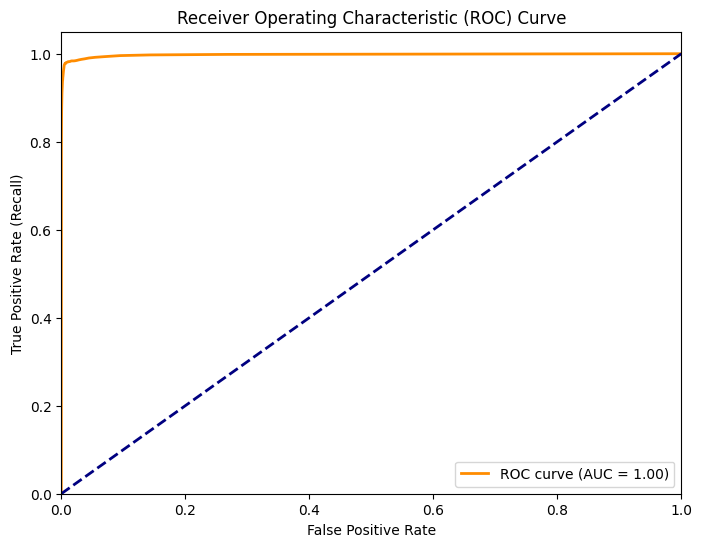

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier (AUC = 0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **ROC Curve Code Walkthrough:**
- **Orange Curve**:
  - Represents the performance of the Random Forest model.
  - The closer it is to the top-left corner, the better the model.
- **Dashed Navy Line**:
  - Represents a random classifier with an AUC of 0.5.
## **Visualization:**
- **X-axis**: False Positive Rate (FPR).
- **Y-axis**: True Positive Rate (Recall).
- **AUC Value**: 0.997 (shows excellent separation between fraud and non-fraud cases).


In [44]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(10))

                importance
merchant_city     0.239200
zip               0.220715
use_chip          0.132968
mcc               0.121523
merchant_state    0.118364
amount            0.062381
merchant_id       0.055896
card_id           0.022612
client_id         0.021527
errors            0.004812


In [45]:
balanced_data.to_csv('/Users/hrishikeshalikatte/Desktop/Final_project/balanced_data.csv', index=False)